# Определение перспективного тарифа для телеком компании.

Нашей задачей является анализ тарифных планов компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В проекте будет реализован предварительный анализ тарифов на небольшой выборке клиентов. У нас есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. В данном проекте мы проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.

# Описание тарифов

***Тариф «Смарт»***
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
  - Минута разговора — 3 рубля. Количество использованных минут и мегабайтов «Мегалайн» всегда округляет вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
  - Сообщение — 3 рубля.
  - 1 Гб интернет-трафика — 200 рублей.

***Тариф «Ультра»***
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
  - Минута разговора — 1 рубль;
  - Сообщение — 1 рубль;
  - 1 Гб интернет-трафика: 150 рублей.

# Описание данных

***Таблица users (информация о пользователях):***

 - user_id — уникальный идентификатор пользователя 
*first_name — имя пользователя
 - last_name — фамилия пользователя
 - age — возраст пользователя (годы)
 - reg_date — дата подключения тарифа (день, месяц, год)
 - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
 - city — город проживания пользователя
 - tariff — название тарифного плана

***Таблица calls (информация о звонках):***

 - id — уникальный номер звонка
 - call_date — дата звонка
 - duration — длительность звонка в минутах
 - user_id — идентификатор пользователя, сделавшего звонок

***Таблица messages (информация о сообщениях):***

 - id — уникальный номер сообщения
 - message_date — дата сообщения
 - user_id — идентификатор пользователя, отправившего сообщение

***Таблица internet (информация об интернет-сессиях):***

 - id — уникальный номер сессии
 - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
 - session_date — дата интернет-сессии
 - user_id — идентификатор пользователя

***Таблица tariffs (информация о тарифах):***

 - tariff_name — название тарифа
 - rub_monthly_fee — ежемесячная абонентская плата в рублях
 - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
 - messages_included — количество сообщений в месяц, включённых в абонентскую плату
 - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
 - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
 - ub_per_message — стоимость отправки сообщения сверх тарифного пакета
 - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Изучение данных из файла

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

## Обзор данных

In [2]:
# загружаем файлы с данными

try:
    calls = pd.read_csv('calls.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')

try:
    sessions = pd.read_csv('internet.csv')
except:
    sessions = pd.read_csv('/datasets/internet.csv')   
    
try:
    messages = pd.read_csv('messages.csv')
except:
    messages = pd.read_csv('/datasets/messages.csv')  
    
try:
    tariffs = pd.read_csv('tariffs.csv')
except:
    tariffs = pd.read_csv('/datasets/tariffs.csv')      
    
try:
    users = pd.read_csv('users.csv')
except:
    users = pd.read_csv('/datasets/users.csv')      

data_list = [calls, sessions, messages, tariffs, users]

#### Посмотрим и подготовим таблицу звонков

In [3]:
# выводим первые 5 строк таблицы
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
# смотрим инфо по таблице
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
# приведем дату к datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

In [6]:
# округлим длительность разговора в большую сторону и приведем к целому значению
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [7]:
# приведем id к int
calls['id'] = calls['id'].astype('int')

In [8]:
# смотрим таблицу
calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


In [9]:
# проверка изменившихся параметров
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int32         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 4.6 MB


#### Посмотрим и подготовим таблицу интернет-сессий

In [10]:
# выводим первые 5 строк таблицы
sessions.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [11]:
# смотрим инфо по таблице
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [12]:
# приведем дату к datetime
sessions['session_date'] = pd.to_datetime(sessions['session_date'], format = '%Y-%m-%d')

In [13]:
# округлим трафик в большую сторону и приведем к целому значению
sessions['mb_used'] = np.ceil(sessions['mb_used']).astype('int')

In [14]:
# приведем id к int
sessions['id'] = sessions['id'].astype('int')

In [15]:
sessions.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,10000,113,2018-11-25,1000
1,1,10001,1053,2018-09-07,1000
2,2,10002,1198,2018-06-25,1000
3,3,10003,551,2018-08-22,1000
4,4,10004,303,2018-09-24,1000


In [16]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  int32         
 2   mb_used       149396 non-null  int32         
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(2)
memory usage: 4.6 MB


#### Посмотрим и подготовим таблицу сообщений

In [17]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [19]:
# приведем дату к datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

In [20]:
# приведем id к int
messages['id'] = messages['id'].astype('int')

In [21]:
messages.head()

,id,message_date,user_id
0,10000,2018-06-27,1000
1,10001,2018-10-08,1000
2,10002,2018-08-04,1000
3,10003,2018-06-16,1000
4,10004,2018-12-05,1000


In [22]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int32         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 2.3 MB


#### Посмотрим и подготовим таблицу тарифов

In [23]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [24]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


#### Посмотрим и подготовим таблицу пользователей

In [25]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [27]:
# приведем даты к datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

38 человек прекратили пользование тарифом

In [28]:
#Удалим столбец Unnamed: 0 из датафрейма sessions
sessions.drop('Unnamed: 0', axis=1, inplace=True)

In [29]:
sessions.head()

,id,mb_used,session_date,user_id
0,10000,113,2018-11-25,1000
1,10001,1053,2018-09-07,1000
2,10002,1198,2018-06-25,1000
3,10003,551,2018-08-22,1000
4,10004,303,2018-09-24,1000


***Создадим:***
 - столбец month в датафрейме calls с номером месяца из столбца call_date.
 - столбец month в датафрейме messages с номером месяца из столбца message_date.
 - столбец month в датафрейме sessions с номером месяца из столбца session_date

In [30]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
sessions['month'] = sessions['session_date'].dt.month

***Посчитаем количество сделанных звонков разговора для каждого пользователя по месяцам.***

In [31]:
# подсчёт количества звонков для каждого пользователя по месяцам
calls_per_month = calls.groupby(['user_id','month']).agg(calls=('duration', 'count'))

In [32]:
# вывод на экран
calls_per_month.head(10)

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63

***Посчитаем количество израсходованных минут разговора для каждого пользователя по месяцам***

In [33]:
# подсчёт израсходованных минут для каждого пользователя по месяцам
minutes_per_month = calls.groupby(['user_id','month']).agg(minutes=('duration', 'sum'))

In [34]:
# вывод первых 15 строк на экран
minutes_per_month.head(15)

minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414
1002    6          117
        7          214
        8          289
        9          206
        10         212

***Посчитаем количество отправленных сообщений по месяцам для каждого пользователя***

In [35]:
# подсчёт количества отправленных сообщений для каждого пользователя по месяцам
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))

In [36]:
# вывод первых 10 строк на экран
messages_per_month.head(10)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11

***Посчитаем количество потраченных мегабайт по месяцам для каждого пользователя***

In [37]:
# подсчёт потраченных мегабайт для каждого пользователя по месяцам
sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})

In [38]:
sessions_per_month.head(20)

mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581
        10       14717
        11       14768
        12        9827
1001    11       18452
        12       14053
1002    6        10871
        7        17601
        8        20347
        9        16712
        10       13905
        11       18610
        12       18137
1003    8         8571
        9        12479
        10       14779

## Анализ данных и подсчёт выручки

Объединяем все посчитанные выше значения в один датафрейм `user_behavior`.
Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [39]:
users['churn_date'].count() / users['churn_date'].shape[0] * 100

7.6

Расторгли договор 7.6% клиентов из датасета

In [40]:
# объединим все в один датафрейм user_behavior
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2256.0,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23257.0,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14016.0,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14070.0,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14581.0,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


***Проверим пропуски в таблице user_behavior после объединения:***

In [41]:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

***Заполним образовавшиеся пропуски в данных:***

In [42]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

***Присоединяем информацию о тарифах***

In [43]:
# переименование столбца tariff_name на более простое tariff

tariffs = tariffs.rename(
    columns={
        'tariff_name': 'tariff'
    }
)

In [44]:
user_behavior = user_behavior.merge(tariffs, on='tariff')

***Считаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф***

In [45]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

***Переводим превышающие тариф мегабайты в гигабайты и сохраняем в столбец paid_gb***

In [46]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

***Считаем выручку за минуты разговора, сообщения и интернет***

In [47]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

***Считаем помесячную выручку с каждого пользователя, она будет храниться в столбец total_cost***

In [48]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

***Датафрейм stats_df для каждой пары "месяц-тариф" будет хранить основные характеристики***

In [49]:
# сохранение статистических метрик для каждой пары месяц-тариф
# в одной таблице stats_df (среднее значение, стандартное отклонение, медиана)

stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(10)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8524.44,18.24,203.85,20.81,6451.84,16.20,154.23,20.5,7107.0,15.0,162.5
1,1,ultra,59.44,13153.56,33.78,428.11,41.64,6872.15,30.67,269.76,51.0,14808.0,32.0,382.0
2,2,smart,40.19,11611.40,24.09,298.69,25.39,6254.55,21.75,190.82,38.5,12572.5,20.0,258.0
3,2,ultra,41.54,11786.96,21.96,297.12,40.97,10654.34,26.77,296.51,25.0,7335.5,5.5,168.0
4,3,smart,54.32,15123.86,31.86,390.05,25.54,5835.46,26.80,191.89,59.0,15690.0,23.0,409.0
5,3,ultra,67.68,17551.97,32.30,489.65,44.84,10961.94,41.62,333.74,57.0,17513.0,20.0,403.0
6,4,smart,51.31,13479.48,30.74,367.13,25.70,5705.03,24.54,186.49,52.0,14104.5,28.0,368.5
7,4,ultra,64.09,16843.80,31.56,458.02,36.27,9727.48,37.51,267.68,61.0,16662.0,17.0,453.0
8,5,smart,55.24,15825.20,33.77,387.36,25.38,5985.18,27.04,186.60,59.0,16343.0,30.0,433.0
9,5,ultra,72.51,19381.19,37.85,510.33,41.08,10055.63,40.31,289.60,75.0,18717.0,25.0,519.0


***Распределение среднего количества звонков по видам тарифов и месяцам***

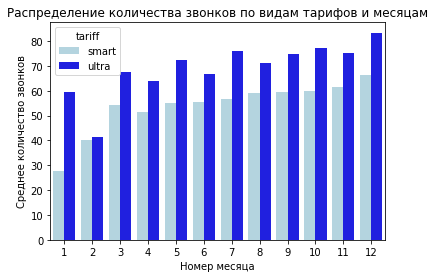

In [50]:
ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение количества звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

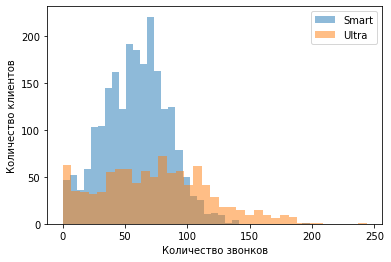

In [51]:
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество звонков')
plt.ylabel('Количество клиентов')
plt.show()

***Распределение средней продолжительности звонков по видам тарифов и месяцам***

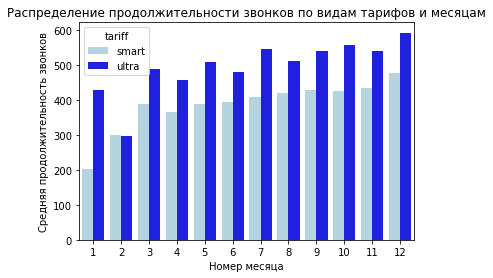

In [52]:
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение продолжительности звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

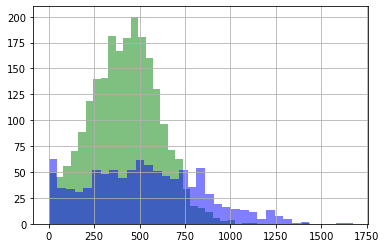

In [53]:
user_behavior[user_behavior['tariff'] =='smart']['minutes'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['minutes'].hist(bins=35, alpha=0.5, color='blue');

***Вывод: Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart. В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.***

***Распределение среднего количества сообщений по видам тарифов и месяцам***

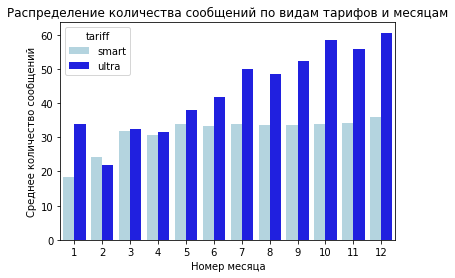

In [54]:
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества сообщений по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество сообщений');

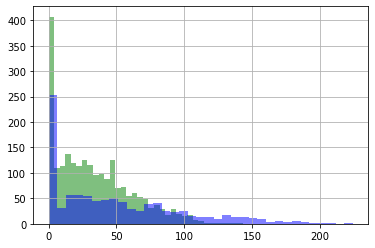

In [55]:
user_behavior[user_behavior['tariff'] =='smart']['messages'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['messages'].hist(bins=35, alpha=0.5, color='blue');

***Вывод: В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart. Количество сообщений в течение года на обоих тарифак растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.***

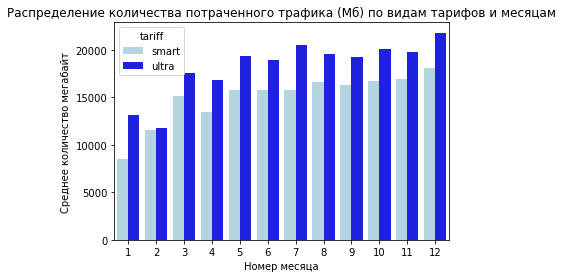

In [56]:
ax = sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

***Сравнение потраченных мегабайт среди пользователей тарифов Smart и Ultra***

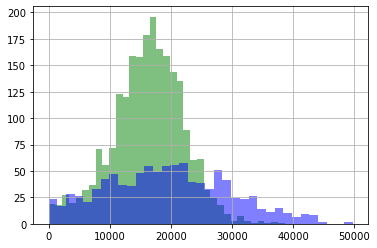

In [57]:
user_behavior[user_behavior['tariff'] =='smart']['mb_used'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['mb_used'].hist(bins=35, alpha=0.5, color='blue');

***Вывод: Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.***

## Проверка гипотез

***Проверка гипотезы:*** средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается

H1: выручка пользователей тарифов «Ультра» и «Смарт» различается

alpha = 0.05

In [58]:
users_ultra = user_behavior.loc[user_behavior['tariff'] =='ultra']['total_cost']
users_smart = user_behavior.loc[user_behavior['tariff'] =='smart']['total_cost']

print('Средняя выручка тарифа "smart": {:.1f}'.format(users_smart.mean()))
print('Средняя выручка тарифа "ultra": {:.1f}'.format(users_ultra.mean()))
print('Полная выручка тарифа "smart": {:.1f}'.format(users_smart.sum()))
print('Полная выручка тарифа "ultra": {:.1f}'.format(users_ultra.sum()))
print('Количество пользователей тарифа "smart": {}'.format(users_smart.count()))
print('Количество пользователей тарифа "ultra": {}'.format(users_ultra.count()))
print('')
# вызов метода для проверки гипотезы
results = st.ttest_ind(users_ultra, users_smart, equal_var=False)

#значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя выручка тарифа "smart": 1294.6
Средняя выручка тарифа "ultra": 2071.1
Полная выручка тарифа "smart": 2885751.0
Полная выручка тарифа "ultra": 2040000.0
Количество пользователей тарифа "smart": 2229
Количество пользователей тарифа "ultra": 985

2.7240946993530856e-246
Отвергаем нулевую гипотезу


***Вывод: Выручка пользователей тарифов «Ультра» и «Смарт» различается***

***Проверка гипотезы:*** пользователи из Москвы приносят больше выручки, чем пользователи из других городов;

H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы`

H_1: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы`

alpha = 0.05

In [59]:
from_moscow = user_behavior[user_behavior['city'] == 'Москва']['total_cost']
not_from_moscow = user_behavior[user_behavior['city'] != 'Москва']['total_cost']

# вызов метода для проверки гипотезы
results = st.ttest_ind(from_moscow, not_from_moscow, equal_var=False)

# значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


***Вывод: С вероятностью в 51% и выше такой результат может быть получен случайно. Это слишком большая вероятность, чтобы делать выводы о значимом различиии между средней выручкой пользователей из Москвы и пользователей из других регионов.***

## Общие выводы

***Провели сравнительный анализ тарифов "Смарт" и "Ультра":***

 - Тариф "Смарт" имеет более низкую абонентскую плату и высокие ограничения по тарифу.
 - Тариф "Ультра" имеет высокую абонентскую плату и широкий пакет включенных минут, SMS сообщений и интернета.

 - Суммарная выручка больше у тарифа "Смарт", т.к. этот тариф имеет больше количество пользователей.
 - Средние по звонкам, смс и интернет трафику у тарифов схожи. SMS сообщениями мало кто пользуется.
 
***В тарифе "Ультра" основная выручка идет из-за абонентской платы***, а не от превышения тарифных условий, как это происходит в тарифе "Смарт".
***Тариф "Ультра" имеет неоправдано большие лимиты по услугам***, большинству пользователей столько не нужно.
***Выручка в различных городах и в Москве с вероятностью 51% и выше не различаются.***

***Тариф "Смарт" популярнее*** т.к. имеет относительно низкую абонентскую плату, но он покрывает основные потребности пользователя. ***Возможно можно создать новый тариф на основе "Смарт",*** но оптимизированный за счет широкого пакета "Ультра" и незначительного повышения абонентской платы. Некий гибрид рассмотренных тарифов.